# Climate Change and CO2 Levels Prediction
Project Discribtion: Developed a quantitative framework for analyzing and forecasting atmospheric CO2 concentration using statistical time series models. Applied data preprocessing, visualization, and stationarity testing to identify trends and seasonal patterns within the dataset spanning from 1958 to 2001 (2284 observations). 

Data Source: Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
 https://gml.noaa.gov/ccgg/trends/index.html


# 1. Introduce Package and Library

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

# 2. Data Loading and Preprocessing

## 2.1 Data Importing

In [2]:
# Introduce the used data
initial_data = pd.read_csv('co2.csv', parse_dates=['date'], index_col='date')
initial_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


missing data:  co2    59
dtype: int64


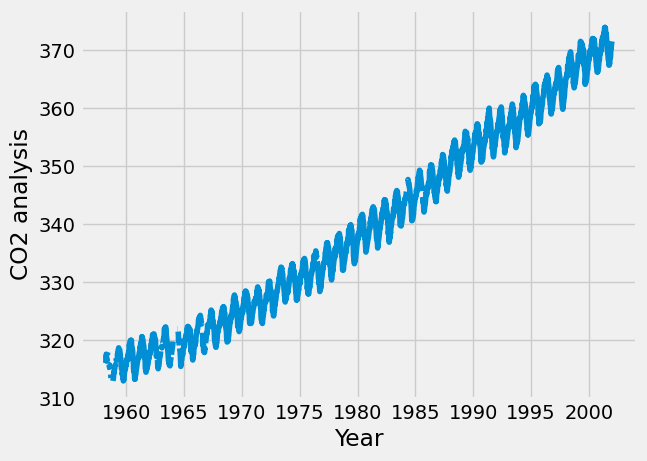

In [3]:
# Visualize the data
plt.xlabel('Year')
plt.ylabel('CO2 analysis')
plt.plot(initial_data)

# Check for missing data
print("missing data: ", initial_data.isnull().sum())

## 2.2 Exploratory Data Analysis and Visualization

5


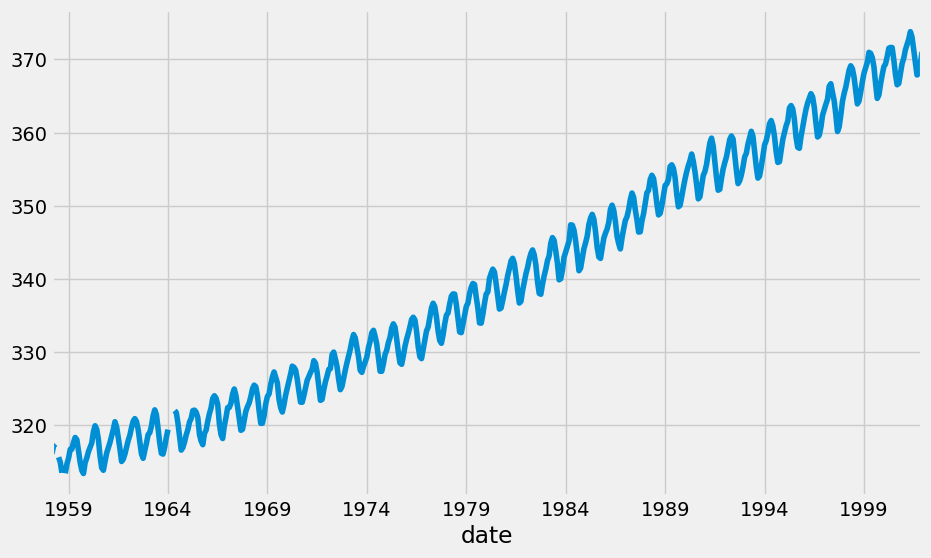

In [4]:
# Resample the data to monthly frequency and take the mean
y = initial_data['co2'].resample('MS').mean()

# Check for missing data again
print(y.isnull().sum())

# Plot the resampled data
y.plot(figsize=(10, 6))
plt.show()

In [5]:
# Get the summary statistics of the data
y.describe()

count    521.000000
mean     339.822665
std       17.068711
min      313.400000
25%      324.125000
50%      337.950000
75%      354.675000
max      373.800000
Name: co2, dtype: float64

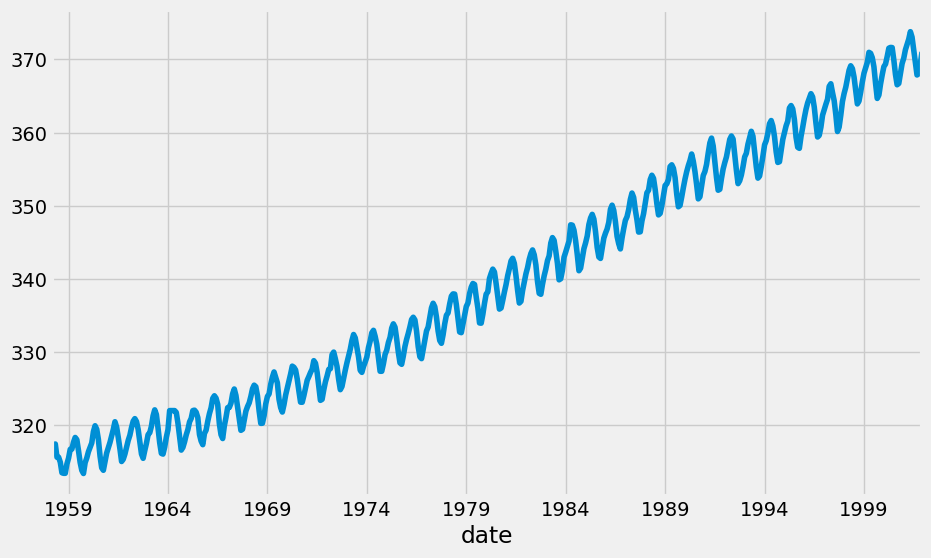

In [6]:
# Fill the missing values through the backward fill method
y = y.fillna(y.bfill())

# Plot the filled data
y.plot(figsize=(10, 6))
plt.show()

# 3. Time Series Decomposition and Stationarity Testing

## 3.1 Time Series Stationarity Test Through Rolling Mean and Standard Deviation

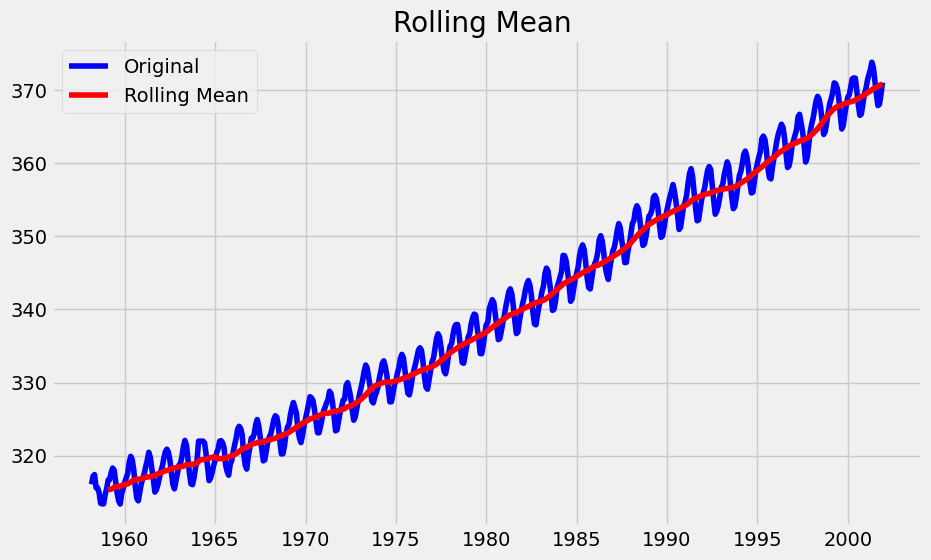

In [7]:
# Calculate rolling statistics with its mean and standard deviation
# Use a rolling window of 12 months to smooth out short-term fluctuations
rollingmean = y.rolling(window=12).mean()
rollingstd = y.rolling(window=12).std()

# Plot the original data and the rolling mean
plt.figure(figsize=(10, 6))
orig = plt.plot(y, color='blue', label='Original')
mean = plt.plot(rollingmean , color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean ')
plt.show(block=False)

### Result Analysis:

The original data(blue line) has an overall upward trend, and year-round fluctuations(Seasonality).

The rolling mean(red line) is increasing, indicating an upward trend in CO2 levels over time.

Therefore, this time series is not stationary

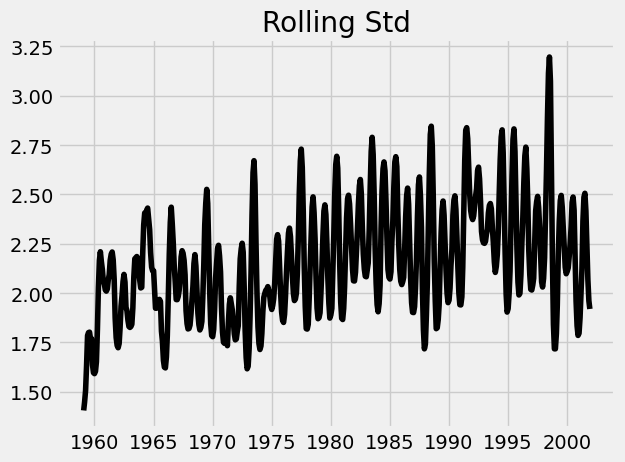

In [8]:
# Plot the rolling standard deviation
std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.title('Rolling Std')
plt.show(block=False)

### Result Analysis: 

The rolling standard deviation is relatively constant, suggesting that the variability in CO2 levels does not change significantly over time.

## 3.2 Time Series Decomposition

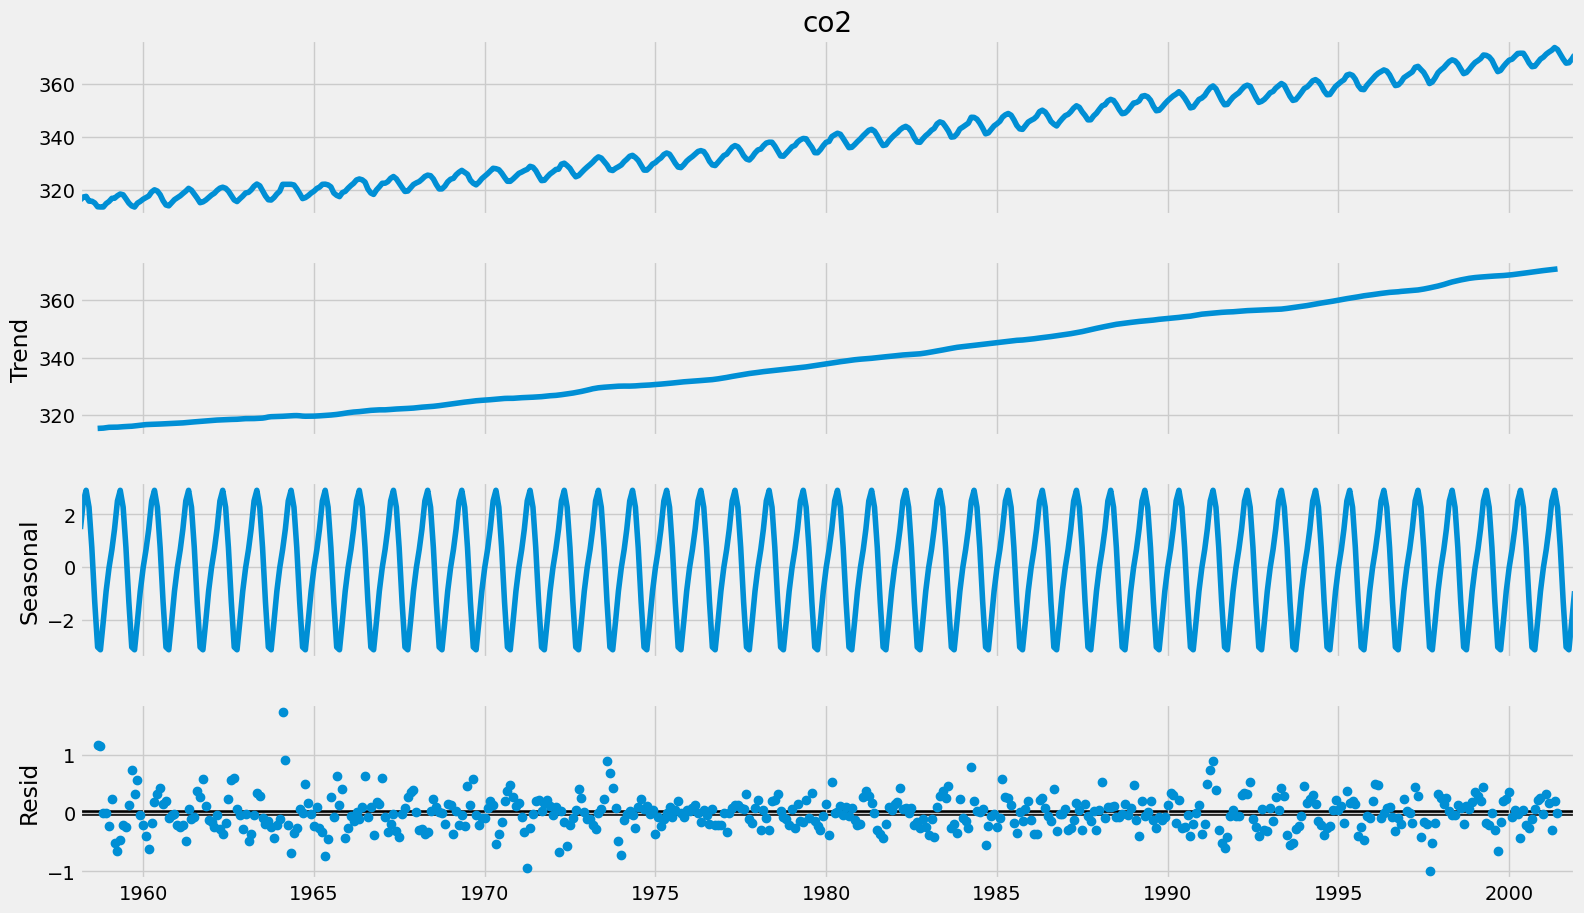

In [9]:
# Decompose the time series into its components(Trend, Seasonality, Residuals)
deco = sm.tsa.seasonal_decompose(y, model='additive')

# Plot the decomposed components
fig = deco.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [10]:
# Check for missing values in the residual component
print(deco.resid.isnull().sum())

12


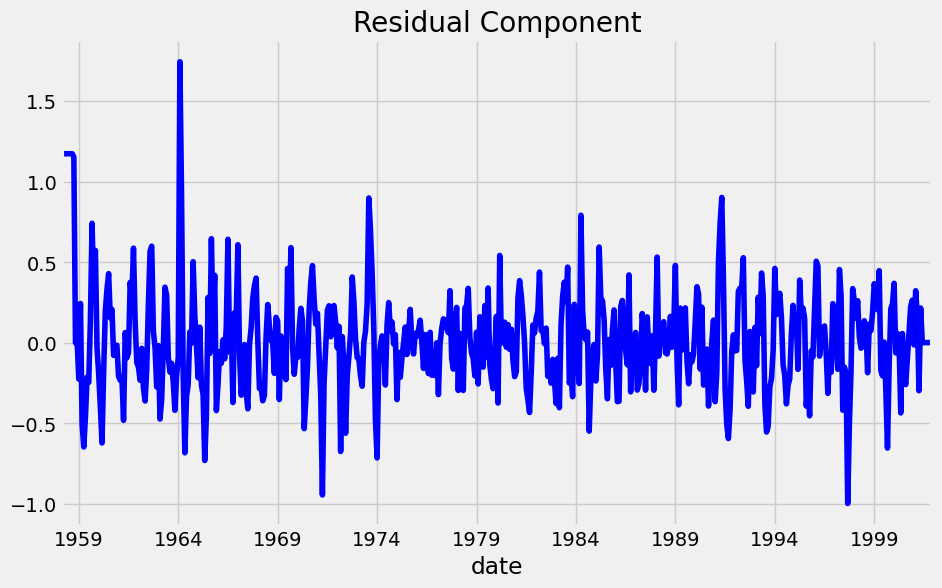

In [11]:
# Fill the missing values in the residual component using backward fill and forward fill methods
CO2Residual = deco.resid
CO2Residual = CO2Residual.fillna(CO2Residual.bfill())
CO2Residual = CO2Residual.fillna(CO2Residual.ffill())

# Plot the residual component
fig = CO2Residual.plot(figsize=(10, 6), color='blue')
plt.title('Residual Component')
plt.show()

In [12]:
# Check for missing values in the trend component
deco.trend.isnull().sum()

12

date
1958-03-01    315.375000
1958-04-01    315.375000
1958-05-01    315.375000
1958-06-01    315.375000
1958-07-01    315.375000
                 ...    
2001-08-01    370.787917
2001-09-01    370.787917
2001-10-01    370.787917
2001-11-01    370.787917
2001-12-01    370.787917
Freq: MS, Name: trend, Length: 526, dtype: float64


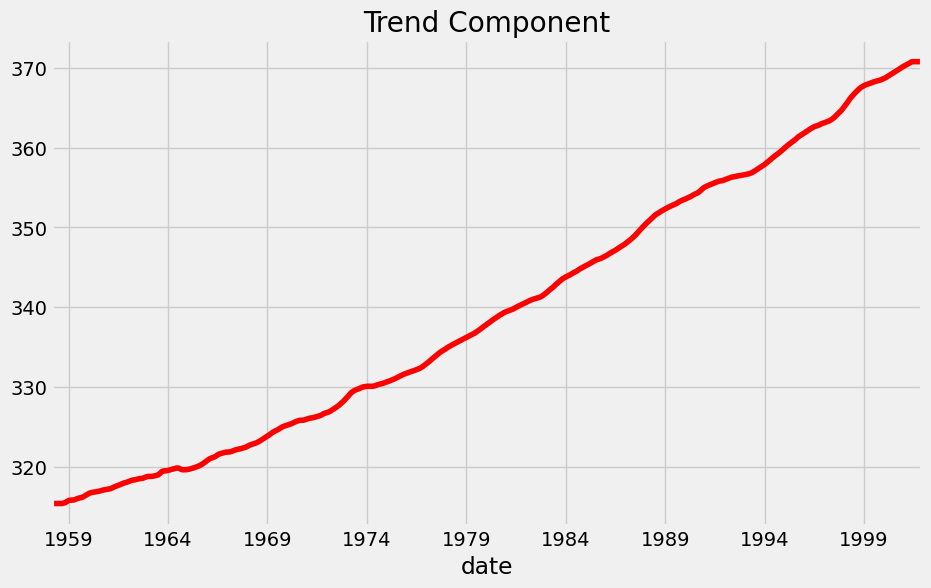

In [13]:
# Fill the missing values in the trend component using backward fill and forward fill methods
CO2trend = deco.trend
CO2trend = CO2trend.fillna(CO2trend.bfill())
CO2trend = CO2trend.fillna(CO2trend.ffill())
print(CO2trend)

# Plot the trend component
CO2trend.plot(figsize=(10, 6), color='red')
plt.title('Trend Component')
plt.show()

## 3.3 Time Series Stationarity Test Through Augmented Dickey-Fuller Test

In [14]:
# Perform the Augmented Dickey-Fuller test on the residual component to check for stationarity
print('Results of Dickey-Fuller Test:')
dftest = adfuller(CO2Residual, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.218187e+01
p-value                        1.345824e-22
#Lags Used                     9.000000e+00
Number of Observations Used    5.160000e+02
Critical Value (1%)           -3.443087e+00
Critical Value (5%)           -2.867158e+00
Critical Value (10%)          -2.569762e+00
dtype: float64


In [15]:
# Show the result of adfuller function and corresponding interpretation
# Null hypothesis is the data is non-stationary, we can reject it
# So the data is stationary
NathanADFresult = adfuller(CO2Residual)

print('ADF Statistic: %f' % NathanADFresult[0])
print('p-value: %f' % NathanADFresult[1])
print('Critical Values:')
for key, value in NathanADFresult[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.181866
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


# 4. Time Series ACF and PACF Plot

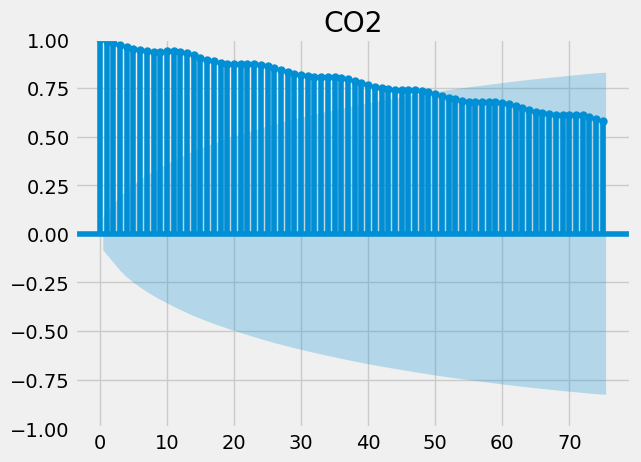

In [16]:
# Plot ACF graph
acf_plot = plot_acf(y,lags=75,title="CO2")
acf_plot.show()

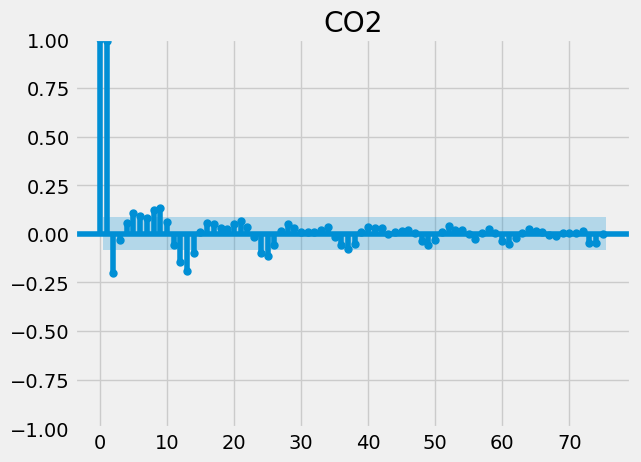

In [17]:
# Plot PACF graph
pacf_plot = plot_pacf(y,lags=75,title="CO2")
pacf_plot.show()

# 5. Time Series Modeling and Diagnostics

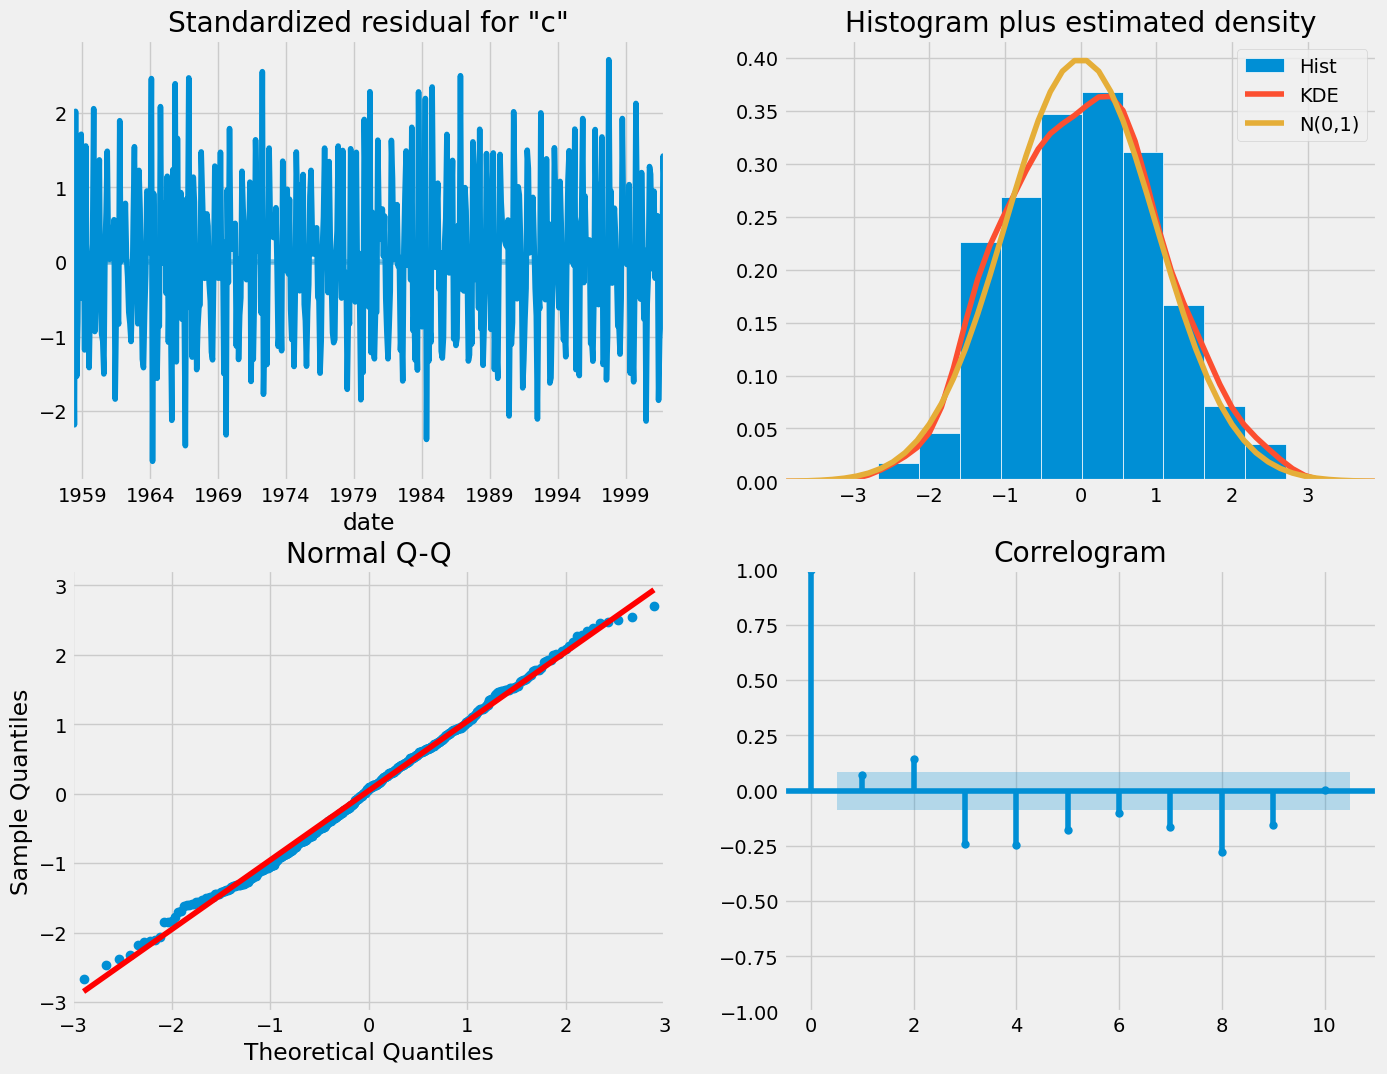

In [18]:
# Construct ARIMA(1, 1, 1) model
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1))

# Fit the model
TSresults = mod.fit(disp=False)

# Plot the diagnostics of the fitted model
TSresults.plot_diagnostics(figsize=(15, 12))
plt.show()

# 6. Dynamic Forecasting and Visualization of Time Series Model

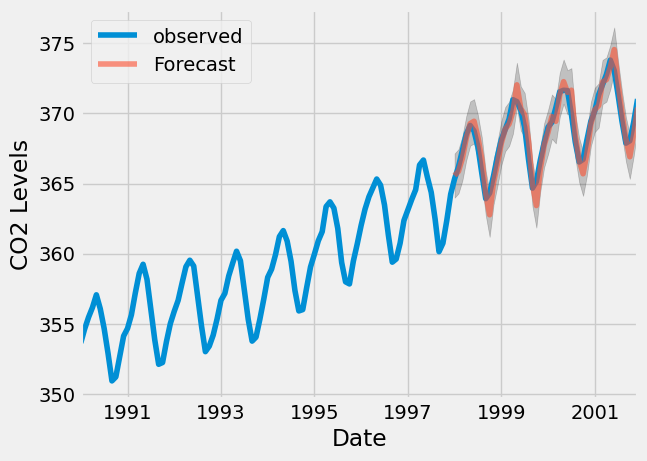

In [19]:
# Returns the one-step-ahead forecast starting from January 1998
pred = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)

# Returns the confidence interval of the fitted parameters.
pred_ci = pred.conf_int()

# Plot the observed data(blue line) and the forecasted data(orange line) along with the confidence intervals(shaded area)
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [20]:
# Extract the predicted and true values of the CO2 levels
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.57


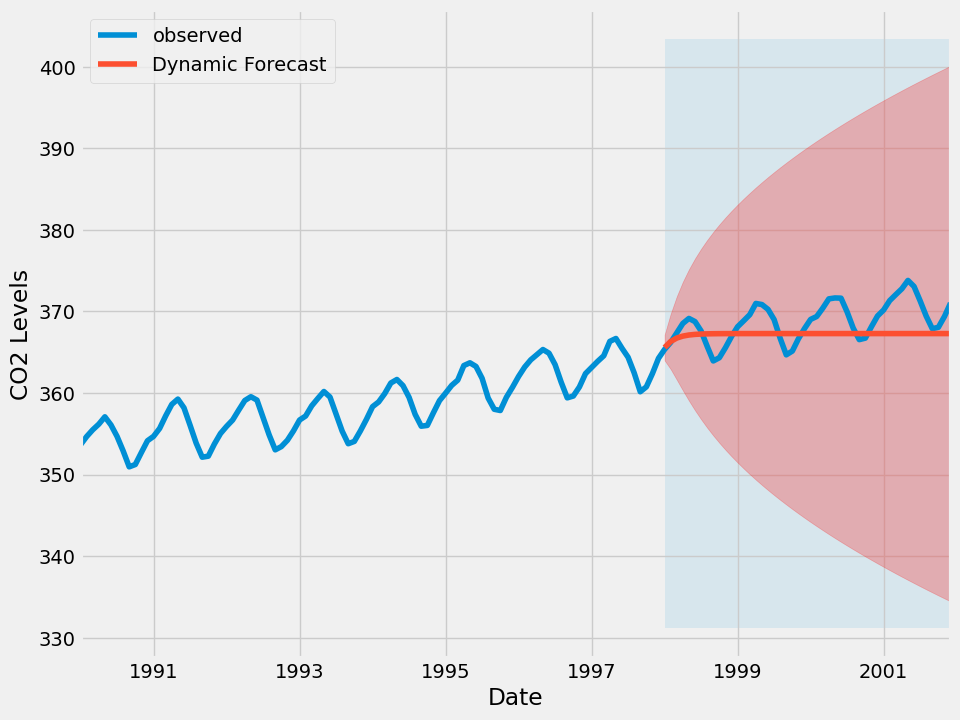

In [21]:
# Returns the dynamic forecast starting from January 1998
pred_dynamic = TSresults.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

# Plot the observed data(blue line) and the forecasted data(orange line) along with the confidence intervals(red area)
ax = y['1990':].plot(label='observed', figsize=(10, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='r', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()